# GAN - Generate Emojis

This notebook contains the code for preparing our emoji dataset and train an emoji generator using a GAN composite model.

The model was initially created from the `How to Develop a GAN for Generating MNIST Handwritten Digits` tutorial from `Jason Brownlee` at [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/). The preprocessing, data augmentation and discriminator model save/load for to resume training were added. The model architecture and hyperparameters were also tuned according to the `UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS` research paper ([available on arxiv.org](https://arxiv.org/pdf/1511.06434.pdf)).

In [28]:
import os, logging

from PIL import Image

from matplotlib import pyplot

from numpy import asarray
from numpy import savez_compressed
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# Display number of available GPUs on the local machine
import tensorflow as tf; print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

# List locals devices available for TensorFlow
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())

# Enable debug logs for TensorFlow
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6273108863899045999
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3134364059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7883350122234826236
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Dataset Preprocessing and Data Augmentation

## Preprocessing

The dataset is preprocessed to resize the original images to 48 x 48 and replacing the transparent background by a 'white' one.

## Data Augmentation

Each image is then fed through a series of data augmentation transformations to generate more training data by applying slight changes such as :

* Rotations
    * 15 degrees counterclockwise
    * 15 degrees clockwise
* Translations
    * 5 pixels to the LEFT
    * 5 pixels to the RIGHT
    * 5 pixels UP
    * 5 pixels DOWN
    * 5 pixels to the TOP LEFT
    * 5 pixels to the TOP RIGHT
* Horizontal Flip

In [4]:
# https://stackoverflow.com/questions/35859140/remove-transparency-alpha-from-any-image-using-pil
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_emojis(emojis_directory, fixed_directory):
    emojis = list()

    # Make sure that the preprocessed images directory exists
    if (not os.path.exists(fixed_directory)):
        os.makedirs(fixed_directory)
    
    # Gather all the filenames in the input images directory
    files = [f for f in os.listdir(emojis_directory) if os.path.isfile(os.path.join(emojis_directory, f))]

    for filename in files:
        # Open the input image
        image = Image.open(f'{emojis_directory}/{filename}')

        # Resize down to 32x32 pixels
        image = image.resize((48, 48))

        # Apply data augmentation transformations
        data_augmentation(image, f'{fixed_directory}/{filename}')

        # Remove the transparency and replace alpha channel with 'white'
        image = remove_transparency(image)

        # Save the processed image
        image.save(f'{fixed_directory}/{filename}')

def data_augmentation(image, filename):
    # Disable the logging for Pillow
    pil_logger = logging.getLogger('PIL')
    pil_logger.setLevel(logging.INFO)

    # Convert image to RGBA to prevent transformations from 
    # leaving a colored background
    if (image.mode != 'RGBA'):
        image = image.convert('RGBA')

    # NOTE:
    # Don't forget to call remove_transparency(...) to replace 
    # the alpha channel with 'white' before saving the image

    # Apply 15 degree rotation to the left
    filename = filename.replace('.png', '-da-nrot.png')
    remove_transparency(image.copy().rotate(-15)).save(filename)

    # Apply 15 degree rotation to the right
    filename = filename.replace('.png', '-da-nrot.png')
    remove_transparency(image.copy().rotate(15)).save(filename)

    # Apply 5 pixel translation to the left
    filename = filename.replace('.png', '-da-tl.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, -5, 0, 1, 0))).save(filename)

    # Apply 5 pixel translation to the right
    filename = filename.replace('.png', '-da-tr.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, 5, 0, 1, 0))).save(filename)

    # Apply 5 pixel translation up
    filename = filename.replace('.png', '-da-tu.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, 0, 0, 1, 5))).save(filename)

    # Apply 5 pixel translation down
    filename = filename.replace('.png', '-da-td.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, 0, 0, 1, -5))).save(filename)

    # Apply 5 pixel translation to the top left
    filename = filename.replace('.png', '-da-tlu.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, -5, 0, 1, -5))).save(filename)

    # Apply 5 pixel translation to the top right
    filename = filename.replace('.png', '-da-tru.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, 5, 0, 1, -5))).save(filename)

    # Apply 5 pixel translation to the bottom left
    filename = filename.replace('.png', '-da-tld.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, -5, 0, 1, -5))).save(filename)

    # Apply 5 pixel translation to the bottom right
    filename = filename.replace('.png', '-da-trd.png')
    remove_transparency(image.copy().transform(image.size, Image.AFFINE, (1, 0, 5, 0, 1, -5))).save(filename)

    # Only flip images that aren't symetrical.
    # filename = f'{self.path}/{emoji["id"]}-{emoji["name"]}-{emojiType}-da-flip.png'
    # image.copy().transpose(Image.FLIP_LEFT_RIGHT).save(filename)

    # Also apply all of the data augmentation on the flipped version.
    # ...

def load_emojis(directory):
    emojis = list()

    # Gather all the filenames in the preprocessed images directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    for filename in files:
        # Open the input image
        image = Image.open(f'{directory}/{filename}')

        # Convert to 'RGB' mode
        image = image.convert('RGB')
        
        # Extract array of pixels from image
        pixels = asarray(image)

        # Append pixels to list of emojis
        emojis.append(pixels)

    return asarray(emojis)

def plot_emojis(emojis, n_grid_size):
    for i in range(n_grid_size * n_grid_size):
        pyplot.subplot(n_grid_size, n_grid_size, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(emojis[i])

    pyplot.show()
    pyplot.close()

Loaded:  (6809, 48, 48, 3)


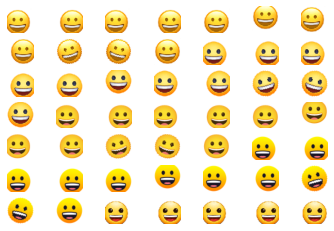

In [6]:
# Apply preprocessing to the dataset
dir_emojis = 'emojis'
dir_emojis_fixed = 'emojis-fixed'
preprocess_emojis(dir_emojis, dir_emojis_fixed)

# Save the clean dataset into a compressed file
emojis = load_emojis(dir_emojis_fixed)
savez_compressed('emojis-dataset.npz', emojis)

# Test reloading the compressed dataset
data = load('emojis-dataset.npz')
emojis = data['arr_0']

# Print dataset details and first X images
print('Loaded: ', emojis.shape)
plot_emojis(emojis, 7)

# 2. Model Definitions (Discriminator, Generator and GAN)

In [8]:
def define_discriminator(in_shape=(48, 48, 3), kernel_size=(3, 3)):
    model = Sequential()
    # Normal
    model.add(Conv2D(64, kernel_size, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 24x24
    model.add(Conv2D(128, kernel_size, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 12x12
    model.add(Conv2D(256, kernel_size, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 6x6
    model.add(Conv2D(512, kernel_size, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim, kernel_size=(5, 5)):
    # weight initialization
    model = Sequential()
    # Foundation for 6x6 feature maps
    n_nodes = 512 * 6 * 6
    model.add(Dense(n_nodes, activation='relu', input_dim=latent_dim))
    # model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 512)))
    # Upsample to 12x12
    model.add(Conv2DTranspose(256, kernel_size, activation='relu', strides=(2, 2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    # Upsample to 24x24
    model.add(Conv2DTranspose(128, kernel_size, activation='relu', strides=(2, 2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    # Upsample to 48x48
    model.add(Conv2DTranspose(64, kernel_size, activation='relu', strides=(2, 2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    # Output layer at 48x48x3
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

def define_gan(d_model, g_model):
    # Freeze the discriminator model's weights from the GAN model
    d_model.trainable = False
    # Connect the discriminator and generator
    model = Sequential()
    # Add the generator
    model.add(g_model)
    # Add the discriminator
    model.add(d_model)
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    # Unfreeze the discriminator model's weights
    d_model.trainable = True
    return model

# 3. Data Generation Functions

These functions are used to generate real or fake samples for training our models.

* The real samples are picked from our preprocessed and compressed dataset.
* The fake samples are generated using the generator model with random points in its latent space.

In [10]:
def load_real_samples(dataset_file='emojis-dataset.npz'):
    data = load(dataset_file)
    X = data['arr_0']
    # Convert from unsigned ints to floats
    X = X.astype('float32')
    # Scale from [0, 255] to [-1, 1] for the 'tanh' activation function
    X = (X - 127.5) / 127.5
    return X

def generate_real_samples(dataset, n_samples):
    # Choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # Retrieve selected images
    X = dataset[ix]
    # Generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    # Generate points in latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Predict outputs
    X = g_model.predict(x_input)
    # Create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# 4. Model Performance Functions

These functions measure, track and display the performance metrics for our models during training. They are also used to save snapshots of our models after a specified number of epochs.

In [23]:
def save_plot(filename, examples, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0

    # plot images
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])

    # Save plot to file
    pyplot.savefig(filename)
    pyplot.close()

def summarize_performance(epoch, d_model, g_model, dataset, latent_dim, n_samples=100, directory='out_dir'):
    # Prepare real samples
    x_real, y_real = generate_real_samples(dataset, n_samples)
    # Evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
    # Prepare fake samples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Evaluate generator on fake samples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # Summarize discriminator performance
    print('> Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    # TODO: Add historical graphs for the loss over time
    # TODO: Track total training time

    # Save the discriminator model to file
    filename = directory + '/e%03d_discriminator.h5' % (epoch+1)
    d_model.save(filename, include_optimizer=True)

    # Save the generator model to file
    filename = directory + '/e%03d_generator.h5' % (epoch+1)
    g_model.save(filename)

    # Save the emojis samples generated at this epoch
    filename = directory + '/emojis_training_e%03d.png' % (epoch+1)
    save_plot(filename, x_fake)

# 5. Training Function 

In [26]:
def train(d_model, g_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch_size=128):
    # Ensure that the output directory exists
    runs_dir = 'runs'
    if (not os.path.exists(runs_dir)):
        os.makedirs(runs_dir)

    # Count how many child directories are in the 'runs' directory
    run_count = sum(os.path.isdir(os.path.join(runs_dir, i)) for i in os.listdir(runs_dir))

    # HACK: Do/While Loop
    while True:
        # Build the output directory name
        out_dir = f'{runs_dir}/run-{run_count}'

        # Increment until we find an unused directory name
        if (os.path.exists(out_dir)):
            run_count += 1
        else:
            # Create the new output directory 
            os.makedirs(out_dir)
            break

    # Calculate batch related parameters
    half_batch = int(n_batch_size / 2)
    batch_per_epoch = int(dataset.shape[0] / n_batch_size)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            # Generate 'fake' samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Update discriminator model weghts
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch_size)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch_size, 1))
            # Update the generator via the discriminator's loss
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Summarize loss on this batch
            print('> %d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))

        # Evaluate the model performance
        if ((i+1) % 5 == 0):
            summarize_performance(i, d_model, g_model, dataset, latent_dim, directory=out_dir)

# 6. Main Logic

This code puts everything together in order to start training our models.

In [27]:
# Size of the latent space
latent_dim = 100

# Create the discriminator
# d_model = define_discriminator()
d_model = load_model('e075_discriminator.h5')

# Create the generator
# g_model = define_generator(latent_dim)
g_model = load_model('e075_generator.h5')

# Create the GAN
gan_model = define_gan(d_model, g_model)

# Load the emojis
dataset = load_real_samples()

# Train!!!
train(d_model, g_model, gan_model, dataset, latent_dim, n_epochs=75)

> 1, 1/53, d1=0.119, d2=0.047, g=6.471
> 1, 2/53, d1=0.095, d2=0.051, g=5.628
> 1, 3/53, d1=0.035, d2=0.159, g=7.117
> 1, 4/53, d1=0.230, d2=0.055, g=6.086
> 1, 5/53, d1=0.097, d2=0.139, g=6.021
> 1, 6/53, d1=0.099, d2=0.102, g=6.447
> 1, 7/53, d1=0.076, d2=0.061, g=6.449
> 1, 8/53, d1=0.116, d2=0.095, g=5.830
> 1, 9/53, d1=0.126, d2=0.111, g=5.895
> 1, 10/53, d1=0.089, d2=0.163, g=6.550
> 1, 11/53, d1=0.137, d2=0.145, g=6.441
> 1, 12/53, d1=0.065, d2=0.022, g=5.982
> 1, 13/53, d1=0.039, d2=0.072, g=6.177
> 1, 14/53, d1=0.100, d2=0.057, g=5.453
> 1, 15/53, d1=0.073, d2=0.096, g=6.604
> 1, 16/53, d1=0.084, d2=0.055, g=5.576
> 1, 17/53, d1=0.127, d2=0.295, g=7.474
> 1, 18/53, d1=0.175, d2=0.042, g=5.915
> 1, 19/53, d1=0.097, d2=0.137, g=5.860
> 1, 20/53, d1=0.086, d2=0.104, g=5.927
> 1, 21/53, d1=0.043, d2=0.024, g=6.845
> 1, 22/53, d1=0.088, d2=0.037, g=5.309
> 1, 23/53, d1=0.044, d2=0.153, g=6.055
> 1, 24/53, d1=0.071, d2=0.051, g=6.530
> 1, 25/53, d1=0.206, d2=0.189, g=5.510
> 1, 26/5

KeyboardInterrupt: 

# 7. Generate Emojis (Extra!)

This code generates batches of emojis using our trained generator. These emojis can be used to explore the latent space of our model.

In [ ]:
def generate_emojis(generator_file, latent_dim):
    # Make sure that the generated samples folder exists
    out_dir = 'runs/generated'
    if (not os.path.exists(out_dir)):
        os.makedirs(out_dir)

    # Load the generator model
    g_model = load_model(generator_file)

    for i in range(100):
        # Prepare fake samples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples=36)

        # Save generate samples
        filename = out_dir + '/emojis_e%03d.png' % (i+1)
        save_plot(filename, x_fake, n=6)

        # TODO: Save the latent space points for later use in our web application!

# Generate some emojis!
generate_emojis('e075_generator.h5', latent_dim)